In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy

from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy.lang.en.stop_words import STOP_WORDS

import networkx as nx

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Unnamed: 0,Header,Content
0,0,\nHyundai Ioniq 5 in Nepal: The World Car of t...,Hyundai Ioniq 5 is the latest premium electric...
1,1,\nLawmakers’ urgent public importance motion a...,"Kathmandu, May 24Lawmakers have registered an ..."
2,2,\nGovt reducing airport infrastructure budget ...,"Kathmandu, May 22The governing is reducing its..."
3,3,\nHypertension is turning into a silent killer...,Hypertension is defined as the force exerted b...
4,4,\nDo 2022 local elections mark the death of al...,"Before the recent local elections, no one had ..."


In [4]:
#extracting only relavant columns
df =  df[['Header','Content']].copy()

In [5]:
df.head()

,Header,Content
0,\nHyundai Ioniq 5 in Nepal: The World Car of t...,Hyundai Ioniq 5 is the latest premium electric...
1,\nLawmakers’ urgent public importance motion a...,"Kathmandu, May 24Lawmakers have registered an ..."
2,\nGovt reducing airport infrastructure budget ...,"Kathmandu, May 22The governing is reducing its..."
3,\nHypertension is turning into a silent killer...,Hypertension is defined as the force exerted b...
4,\nDo 2022 local elections mark the death of al...,"Before the recent local elections, no one had ..."


In [6]:
#remove '\n' 
df = df.replace(r'\n','',regex=True)
df.head()

,Header,Content
0,Hyundai Ioniq 5 in Nepal: The World Car of the...,Hyundai Ioniq 5 is the latest premium electric...
1,Lawmakers’ urgent public importance motion aga...,"Kathmandu, May 24Lawmakers have registered an ..."
2,Govt reducing airport infrastructure budget to...,"Kathmandu, May 22The governing is reducing its..."
3,Hypertension is turning into a silent killer i...,Hypertension is defined as the force exerted b...
4,Do 2022 local elections mark the death of alte...,"Before the recent local elections, no one had ..."


In [7]:
nlp =spacy.load('en_core_web_md')

In [8]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [9]:
nlp.add_pipe('sentencizer')

In [10]:
#tokenization
for i in range(len(df)):
    df['Header'][i] = nlp(str(df['Header'][i]))
    df['Content'][i] = nlp(str(df['Content'][i]))

In [11]:
df.head()

,Header,Content
0,"(Hyundai, Ioniq, 5, in, Nepal, :, The, World, ...","(Hyundai, Ioniq, 5, is, the, latest, premium, ..."
1,"(Lawmakers, ’, urgent, public, importance, mot...","(Kathmandu, ,, May, 24Lawmakers, have, registe..."
2,"(Govt, reducing, airport, infrastructure, budg...","(Kathmandu, ,, May, 22The, governing, is, redu..."
3,"(Hypertension, is, turning, into, a, silent, k...","(Hypertension, is, defined, as, the, force, ex..."
4,"(Do, 2022, local, elections, mark, the, death,...","(Before, the, recent, local, elections, ,, no,..."


In [12]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'sentencizer']

In [13]:
#lemmatize Header and remove stop words
def lematize_sentence(sen):
    list2=[]
    for token in sen:
        if token.is_stop == True:
            continue
        list2.append(token.lemma_)
    return list2

list1=[]
for i in range(len(df)):
    list1.append(lematize_sentence(df['Header'][i]))

df['lem_Header']=list1

In [14]:
#lemmatize Content and remove stop words
def lematize_sentence(sen):
    list2=[]
    for token in sen:
        if token.is_stop == True:
            continue
        list2.append(token.lemma_)
    return list2

list1=[]
for i in range(len(df)):
    list1.append(lematize_sentence(df['Content'][i]))

df['lem_Content']=list1

In [15]:
df.head()

,Header,Content,lem_Header,lem_Content
0,"(Hyundai, Ioniq, 5, in, Nepal, :, The, World, ...","(Hyundai, Ioniq, 5, is, the, latest, premium, ...","[Hyundai, Ioniq, 5, Nepal, :, World, Car, Year...","[Hyundai, Ioniq, 5, late, premium, electric, S..."
1,"(Lawmakers, ’, urgent, public, importance, mot...","(Kathmandu, ,, May, 24Lawmakers, have, registe...","[lawmaker, ’, urgent, public, importance, moti...","[Kathmandu, ,, 24lawmaker, register, urgent, p..."
2,"(Govt, reducing, airport, infrastructure, budg...","(Kathmandu, ,, May, 22The, governing, is, redu...","[govt, reduce, airport, infrastructure, budget...","[Kathmandu, ,, 22The, governing, reduce, airpo..."
3,"(Hypertension, is, turning, into, a, silent, k...","(Hypertension, is, defined, as, the, force, ex...","[hypertension, turn, silent, killer, Nepal, .,...","[hypertension, define, force, exert, circulate..."
4,"(Do, 2022, local, elections, mark, the, death,...","(Before, the, recent, local, elections, ,, no,...","[2022, local, election, mark, death, alternati...","[recent, local, election, ,, give, Balen, Shah..."


In [16]:
#converting all lemmatized token into sentences
sentences = []
for text in df['lem_Content']:
    sen = ' '.join(text)
    sentence = [i for i in nlp(sen).sents]
    sentences.extend(sentence)
    
for text in df['lem_Header']:
    sen = ' '.join(text)
    sentence = [i for i in nlp(sen).sents]
    sentences.extend(sentence)

In [17]:
#Entity Pair Extraction
def get_entities(entry):
  ent1 = ""
  ent2 = ""

  prev_tok_dep = ""     # dependency tag of previous token in the sentence
  prev_tok_text = ""    # previous token in the sentence

  
  prefix = ""
  modifier = ""


  for tok in nlp(entry):
    # if token is punctuation, move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then adding the current word to it
        if prev_tok_dep == "compound":
          prefix = prev_tok_text + " "+ tok.text

      # check: token is a modifier
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then adding the current word to it
        if prev_tok_dep == "compound":
          modifier = prev_tok_text + " "+ tok.text

      # capture subject
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        # resetting the variables
        prefix = ""
        modifier = ""
        prev_tok_dep = ""
        prev_tok_text = ""

      # capture object
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix + " "+ tok.text
        # resetting the variables
        prefix = ""
        modifier = ""
        prev_tok_dep = ""
        prev_tok_text = ""

      
      prev_tok_dep = tok.dep_
      prev_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]


In [18]:
#getting entity pair of all sentences
entity_pair =[]

for sentence in sentences:
    entity_pair.append(get_entities(sentence.text))


In [19]:
#Relation Extraction
def get_relation(entry):

  # creating a spaCy object
  doc = nlp(entry)

  # creating a matcher class object 
  matcher = Matcher(nlp.vocab)

  # defining the pattern 
  pattern = [{'DEP':'ROOT'},            # finds root word in the sentence
            {'DEP':'prep','OP':"?"},    # checks if it is followed by preposition
            {'DEP':'agent','OP':"?"},   # checks if it is followed by agent
            {'POS':'ADJ','OP':"?"}]     # checks adjective part of speech 

  # adding rule to the matcher
  matcher.add("match_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1
  try:  
      span = doc[matches[k][1]:matches[k][2]] 
  #for empty strings
  except:
      span = ""
      return span
  return (span.text)

In [20]:
#get relations
relations=[]

for sentence in sentences:
    relations.append(get_relation(sentence.text))


In [21]:
# looking at the most frequent relations
pd.Series(relations).value_counts()[:20]

say         44
come        14
include     10
take         8
see          7
offer        7
get          7
write        6
support      6
receive      6
add          5
give         5
run          5
speak        4
continue     4
release      4
reduce       4
provide      4
tell         4
increase     4
dtype: int64

In [22]:
#Building Knowledge graph

# extracting subject
source = [i[0] for i in entity_pair]

# extracting object
target = [i[1] for i in entity_pair]

graph_df = pd.DataFrame({'SOURCE':source, 'TARGET':target, 'EDGE':relations})

In [23]:
# creating a directed-graph from a dataframe
graph = nx.from_pandas_edgelist(graph_df, "SOURCE", "TARGET", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

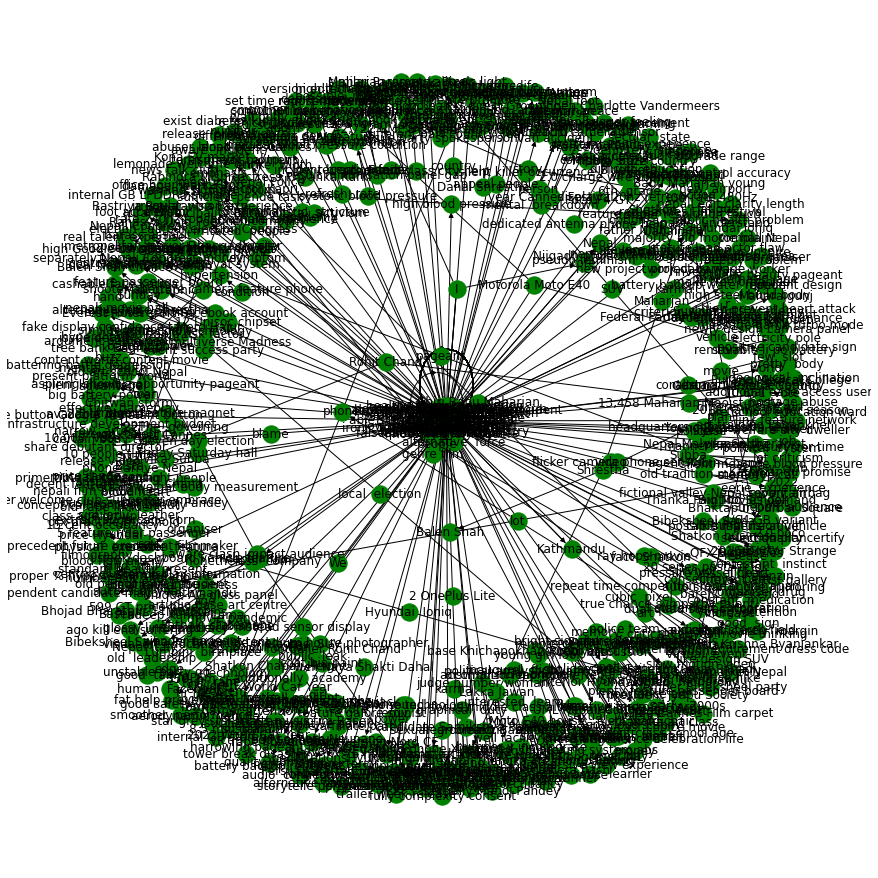

In [24]:
# plotting the network
plt.figure(figsize=(12,12))

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='green', pos = pos)
plt.show()


In [25]:
# some conflicts with the latest version of networkx
# pip install networkx==2.6.3

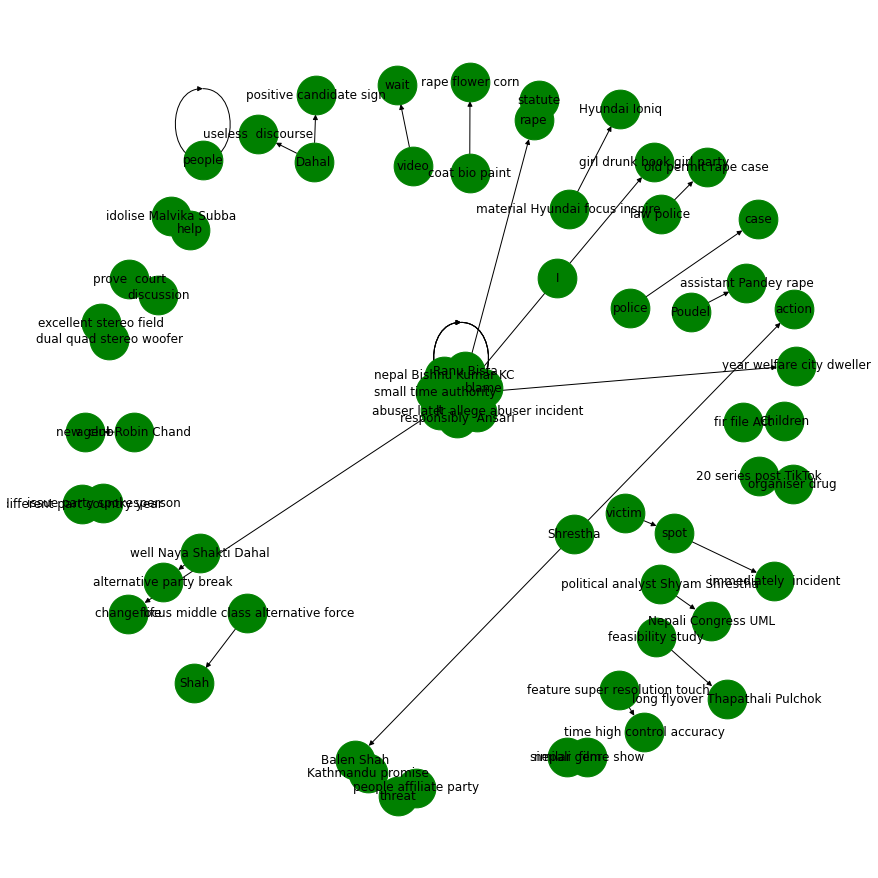

In [26]:
#Observing highest frequency relation (say)
graph_1 = nx.from_pandas_edgelist(graph_df[graph_df['EDGE']=="say"], "SOURCE", "TARGET", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(graph_1)
nx.draw(graph_1, with_labels=True, node_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [27]:
#save graph
nx.write_gpickle(graph,'onlineKhabar25March2022.gpickle')